In [7]:
#基于定位不准确的原因，手动调一下经纬度的偏移量
from mintpy.utils import readfile
from mintpy.utils import writefile
fname_lat = 'lat.rdr.mli'
out_file_lat = 'lat.rdr.mli'
data_lat, atr_lat = readfile.read_binary_file(fname_lat, datasetName=None, box=None, xstep=1, ystep=1)
data_lat = data_lat+0.028
out_file_lat = writefile.write_binary(data_lat, out_file_lat, data_type=None, interleave='BIL')

fname_lon = 'lon.rdr.mli'
out_file_lon = 'lon.rdr.mli'
data_lon, atr_lon = readfile.read_binary_file(fname_lon, datasetName=None, box=None, xstep=1, ystep=1)
data_lon = data_lon+0.016
out_file_lon = writefile.write_binary(data_lon, out_file_lon, data_type=None, interleave='BIL')

In [21]:
%matplotlib inline
import os
import numpy as np
import platform
from matplotlib import pyplot as plt
from mintpy.utils import ptime, readfile, writefile, isce_utils, utils as ut, plot as pp
from mintpy.cli import geocode, view
from mintpy.view import prep_slice, plot_slice
plt.rcParams.update({'font.size': 12})

ds_name = ['S1_D033_20250319_20250331_RG', 'S1_D033_20250319_20250331_AZ'][1]
work_dir = '/penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1'
redo = True

os.chdir(work_dir)
print('Go to directory:', work_dir)

# grid
S, N, W, E = 16.5, 24, 94, 98   # same as Fig. 1;  36.0, 39.0, 35.8, 38.8
step = 0.00277778   # deg (~300 m)  # set to None to calculate product resolution for reference

# input files
off_file = os.path.join(work_dir, 'filt_dense_offsets.bil')
cov_file = os.path.join(work_dir, 'dense_offsets_cov.bil')
snr_file = os.path.join(work_dir, 'dense_offsets_snr.bil')
lat_file = os.path.join(work_dir, 'lat.rdr.mli')
lon_file = os.path.join(work_dir, 'lon.rdr.mli')
los_file = os.path.join(work_dir, 'los.rdr.mli')
hgt_file = os.path.join(work_dir, 'z.rdr.mli')
msk_file = os.path.join(work_dir, 'waterMask.rdr')
xml_file = os.path.join(work_dir, '../../referencedir/IW1.xml')
atr = readfile.read_attribute(off_file)

# output files
rdr_file = os.path.join(work_dir, 'offRg.h5' if ds_name.endswith('RG') else 'offAz.h5')

Go to directory: /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1


In [22]:
# utils functions
def read_offset():
    # calculate pixel_size (to convert offset unit from pixel to meters)
    meta = isce_utils.extract_isce_metadata(xml_file, update_mode=False)[0]

    obs_dir = 'range' if ds_name.endswith('RG') else 'azimuth'
    if obs_dir == 'range':
        pixel_size = float(meta['RANGE_PIXEL_SIZE'])
        print('Slant range pixel size: {:.2f} m'.format(pixel_size))
    else:
        Re, h_sat = float(meta['EARTH_RADIUS']), float(meta['HEIGHT'])
        pixel_size = float(meta['AZIMUTH_PIXEL_SIZE']) * Re / (Re + h_sat)
        print('Ground azimuth pixel size: {:.2f} m'.format(pixel_size))

    # read data / attribute
    off = readfile.read(off_file, datasetName=f'{obs_dir}Offset')[0] * pixel_size
    off_std = np.sqrt(readfile.read(cov_file, datasetName=f'{obs_dir}OffsetStd')[0]) * pixel_size
    off_snr = readfile.read(snr_file)[0]

    return off, off_std, off_snr


def mask_offset(off, off_std, off_snr, config):
    # 1. ignore no-data-value
    no_data_value = readfile.get_no_data_value(off_file)
    off[off == no_data_value] = np.nan
    print(f'# of pixels after removing no-data-value ({no_data_value}): {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    # 2. ignore water body
    water_mask = readfile.read(msk_file)[0]
    off[water_mask == 0] = np.nan
    off_std[water_mask == 0] = np.nan
    off_snr[water_mask == 0] = np.nan
    print(f'# of pixels after removing water body: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')
    off_raw = np.array(off, dtype=np.float32)

    # 3. remove pixels with abnormal offset
    off_std[np.isnan(off)] = np.nan
    off[np.abs(off) > config['max_off']] = np.nan
    print(f'# of pixels after removing offset > {config["max_off"]}: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    # 4. remove pixels with low offset SNR
    off[np.isnan(off_snr)] = np.nan
    flag = off_snr < config['min_snr']    # remove pixels with low SNR value
    flag[np.abs(off / off_std) > 3] = 0   # keep   pixels with high off / off_std
    flag[off_snr < 1] = 1                 # remove pixels with very low SNR value
    off[flag] = np.nan
    print(f'# of pixels after removing SNR < {config["min_snr"]}: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    # 5. remove pixels with high offset STD
    off_std[off_std > config['max_off']/2] = np.nan
    off[np.isnan(off_std)] = np.nan
    off[off_std > config['max_std']] = np.nan
    print(f'# of pixels after removing STD > {config["max_std"]}: {count(off)} out of {off.size} ({count(off)/off.size*100:.1f}%)')

    return off, off_std, off_snr, off_raw


def count(data):
    """Count the number of valid pixels"""
    return np.sum(~np.isnan(data))

print('warm up utils functions.')

warm up utils functions.


extract metadata from ISCE/topsStack xml file: /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/../../referencedir/IW1.xml
Ground azimuth pixel size: 14.07 m
# of pixels after removing no-data-value (-10000.0): 1859256 out of 1859256 (100.0%)
# of pixels after removing water body: 1665508 out of 1859256 (89.6%)
# of pixels after removing offset > 5: 1646387 out of 1859256 (88.6%)
# of pixels after removing SNR < 3: 1593246 out of 1859256 (85.7%)
# of pixels after removing STD > 1.5: 1494252 out of 1859256 (80.4%)
create HDF5 file: /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/offAz.h5 with w mode


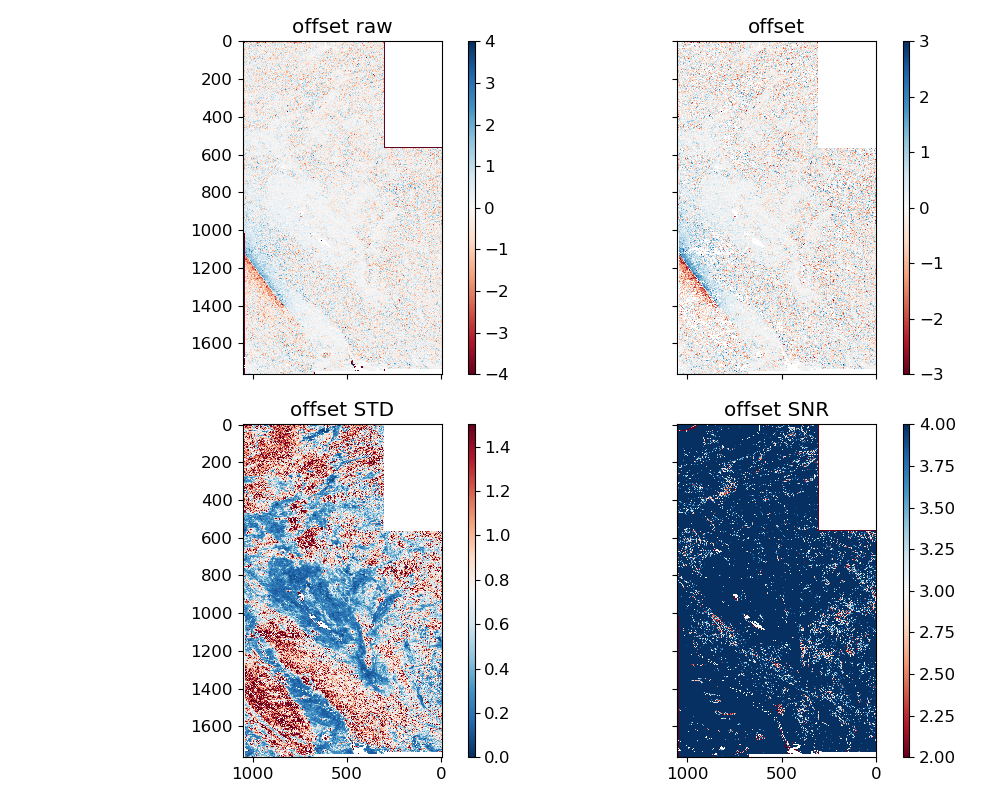

In [23]:
config = {
    'S1_D033_20250319_20250331_RG': {'max_off': 5, 'min_snr': 5, 'max_std': 0.5},
    'S1_D033_20250319_20250331_AZ': {'max_off': 5, 'min_snr': 3, 'max_std': 1.5},
}[ds_name]

# read and mask
off, off_std, off_snr = read_offset()
off, off_std, off_snr, off_raw = mask_offset(off, off_std, off_snr, config)

# write to one HDF5 files
atr['ORBIT_DIRECTION'] = 'ASCENDING' if ds_name.startswith('S1_A') else 'DESCENDING'
if redo or not os.path.isfile(rdr_file):
    ds_dict      = {'displacement' : np.array(off, dtype=np.float32), 'displacementStd' : np.array(off_std, dtype=np.float32)}
    ds_unit_dict = {'displacement' : 'm', 'displacementStd' : 'm'}
    writefile.write(ds_dict, out_file=rdr_file, metadata=atr, ds_unit_dict=ds_unit_dict, compression='lzf', print_msg=False)

# plot
%matplotlib widget
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[10, 8], sharex=True, sharey=True)
for ax, data, [vmin, vmax], cmap, title in zip(axs.flatten(), [off_raw, off, off_std, off_snr], [[-4, 4], [-3, 3], [0, config['max_std']], [2, config['min_snr']+1]], ['RdBu', 'RdBu', 'RdBu_r', 'RdBu'], ['offset raw', 'offset', 'offset STD', 'offset SNR']):
    im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest'); fig.colorbar(im, ax=ax, aspect=50); pp.auto_flip_direction(atr, ax, print_msg=False); ax.set_title(title)
fig.tight_layout()
plt.show()

In [24]:
if step is None:
    iw_xml_file = os.path.join(proj_dir, ds_name, 'referencedir/IW1.xml')
    meta = isce_utils.extract_isce_metadata(iw_xml_file)[0]
    meta['WIDTH'] = int(atr['WIDTH']) * 64
    ystep_m = ut.azimuth_ground_resolution(meta) * 32;  ystep_d = ystep_m / 108e3
    xstep_m = ut.range_ground_resolution(meta) * 64;    xstep_d = xstep_m / (108e3 * np.cos(np.deg2rad(37)))
    print(f'y/x step: {ystep_m:.1f} / {xstep_m:.1f} m; {ystep_d:.4f}, {xstep_d:.4f} deg')

geocode.py /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/offAz.h5 --dset displacement -o /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/offAz.geo --lat-file /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/lat.rdr.mli --lon-file /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/lon.rdr.mli --fill nan --bbox 16.5 24 94 98 --lalo -0.00277778 0.00277778
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/lat.rdr.mli
output pixel size in (lat, lon) in degree: (-0.00277778, 0.00277778)
output area extent in (S, N, W, E) in degree: (16.499994, 24.0, 94.0, 98.0000032)
output file row / column number: (2700, 1440)
[1/1] preparing geometry for dest_box: (0, 0, 1440, 2700) --> full src_box: (0, 0, 1054, 1764)
--------------------------------------------------
res

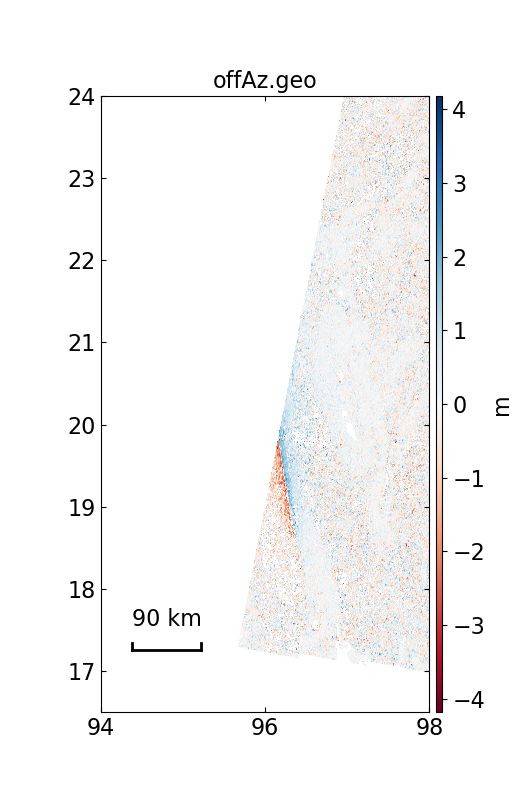

In [25]:
opt = f'--lat-file {lat_file} --lon-file {lon_file} --fill nan --bbox {S} {N} {W} {E} --lalo -{step} {step}'
fbase = os.path.splitext(rdr_file)[0]
io_files = [
    [rdr_file, '--dset displacement',    f'{fbase}.geo'],      # offset
    [rdr_file, '--dset displacementStd', f'{fbase}Std.geo'],   # offset STD
    [los_file, '', os.path.join(work_dir, 'los.geo')]          # offset geometry
]
for ifile, dset, ofile in io_files:
    if redo or not os.path.isfile(ofile):
        cmd = f'{ifile} {dset} -o {ofile} {opt}'
        print(f'geocode.py {cmd}')
        geocode.main(cmd.split())

# plot
view.main(f'{fbase}.geo -c RdBu --noverbose'.split())

In [26]:
from mintpy.cli import load_data, smallbaselineApp
# write geometry HDF5 file
config = f"""# vim: set filetype=cfg:
########## 1. Load Data (--load to exit after this step)
## load_data.py -H to check more details and example inputs.
mintpy.load.processor        = isce
##---------for ISCE only:
mintpy.load.metaFile         = {os.path.join(work_dir, '../../referencedir/IW1.xml')}
mintpy.load.baselineDir      = None
##---------geometry datasets:
mintpy.load.demFile          = {hgt_file}
mintpy.load.lookupYFile      = {lat_file}
mintpy.load.lookupXFile      = {lon_file}
mintpy.load.incAngleFile     = {los_file}
mintpy.load.azAngleFile      = {los_file}
mintpy.load.waterMaskFile    = {msk_file}
"""
sname, oname = ds_name.split('_')[:2]
config_file = os.path.join(work_dir, f'{sname}_{oname}.txt')
print('write MintPy configuration to file: {}'.format(config_file))
with open(config_file, "w") as fid:
    fid.write(config)
smallbaselineApp.main(f'{config_file} -g'.split())
# write geometryRadar.h5
load_data.main(f'-t smallbaselineApp.cfg --geom'.split())
# write geometryGeo.h5
geocode.main(f'./inputs/geometryRadar.h5 -o ./inputs/geometryGeo.h5 {opt}'.split())

write MintPy configuration to file: /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/S1_D033.txt
--------------------------------------------------
Project name: S1_D033
Go to work directory: /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1
read custom template file: /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/S1_D033.txt
update default template based on input custom template
No new option value found, skip updating /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/smallbaselineApp.cfg
copy S1_D033.txt          to inputs   directory for backup.
copy S1_D033.txt          to pic      directory for backup.
read default template file: /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/smallbaselineApp.cfg
Go back to directory: /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1

################################################
   Normal end of small

/home/eedy/tools/MintPy/src/mintpy/load_data.py:711: UserWarning: prep_isce.py failed. Assuming its result exists and continue...
  warnings.warn('prep_isce.py failed. Assuming its result exists and continue...')


[1/1] preparing geometry for dest_box: (0, 0, 1440, 2700) --> full src_box: (0, 0, 1054, 1764)
--------------------------------------------------
resampling file: ./inputs/geometryRadar.h5
--------------------------------------------------
grab dataset structure from ref_file: ./inputs/geometryRadar.h5
create HDF5 file: ./inputs/geometryGeo.h5 with w mode
create dataset  : azimuthAngle       of float32                   in size of (2700, 1440)         with compression = lzf
create dataset  : height             of float32                   in size of (2700, 1440)         with compression = lzf
create dataset  : incidenceAngle     of float32                   in size of (2700, 1440)         with compression = lzf
create dataset  : latitude           of float32                   in size of (2700, 1440)         with compression = lzf
create dataset  : longitude          of float32                   in size of (2700, 1440)         with compression = lzf
create dataset  : slantRangeDistance 

In [27]:
# add some metadata
meta = readfile.read_roipac_rsc(f'../../referencedir/data.rsc')
atr0 = readfile.read_attribute('./offRg.geo')
for key in atr0.keys():
    if key in meta.keys():
        meta.pop(key)
meta['DATE12'] = ptime.yymmdd_date12(ptime.get_date12_from_path(ds_name))
meta['FILE_TYPE'] = 'displacement'
ut.add_attribute('./offRg.geo', meta, print_msg=True)

All updated (removed) attributes already exists (do not exists) and have the same value, skip update.


'./offRg.geo'

run view.py in MintPy version 1.6.1.post18, date 2025-01-14
input file is isce filt_dense_offsets file: /penguin/eedy/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/offAz.geo in float32 format
file size in y/x: (2700, 1440)
num of datasets in file offAz.geo: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 1440, 2700)
subset coverage in y/x: (0, 0, 1440, 2700)
data   coverage in lat/lon: (94.0, 24.0, 98.0000032, 16.499994)
subset coverage in lat/lon: (94.0, 24.0, 98.0000032, 16.499994)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: S1_D033_20250319_20250331_AZ
figure size : [5.3, 8.0]
reading data ...
masking pixels with NO_DATA_VALUE of -10000.0
data    range: [-4.17677, 4.17677] m
display range: [-4.0, 4.0] m
reading DEM: elevation_mli.dem ...
display data in transpa

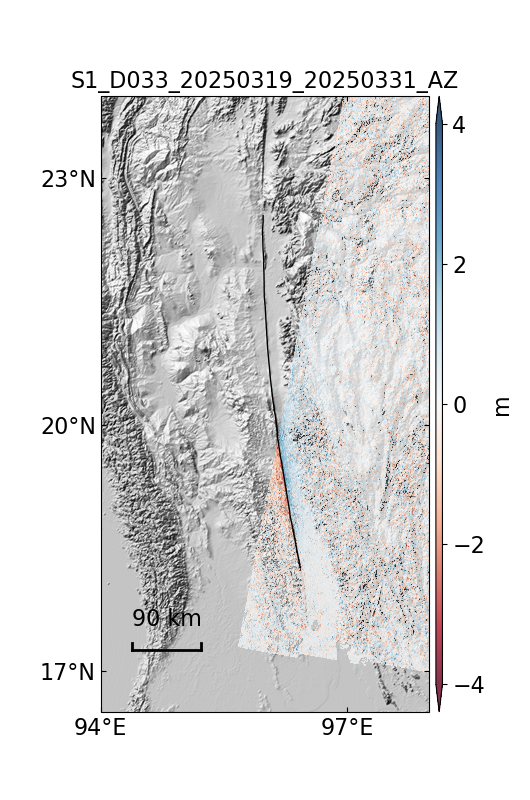

In [29]:
dis_file = f'{fbase}.geo'
dem_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/DEM/elevation_mli.dem')
flt_file = os.path.join(f'/home/eedy/penguin/25EQ_myanmar/simple_rupture_trace.lonlat')
out_file = os.path.join(work_dir, f'{ds_name}.png')
cmd = f'{dis_file} --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} --faultline-lw 1 '
cmd += f'-c RdBu -v -4 4 --lalo-label --lalo-step 3 --cbar-nbins 5 --scalebar 0.2 0.20 0.10 --title {ds_name} '
cmd += f'-o {out_file} '
view.main(cmd.split())